In [1]:
#Qiskit Machine Learning - Option Pricing with qGANs¶
#qGAN can facilitate the pricing of a European call option
#a qGAN can be trained such that a quantum circuit models the spot price of an asset underlying a European call option. 
#The resulting model can then be integrated into a Quantum Amplitude Estimation based algorithm to evaluate the expected payoff 
#Paper: Quantum Generative Adversarial Networks for Learning and Loading Random Distributions. Zoufal, Lucchi, Woerner. 2019.

import matplotlib.pyplot as plt
import numpy as np

from qiskit import Aer, QuantumRegister, QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import TwoLocal, NormalDistribution
from qiskit.quantum_info import Statevector

from qiskit.aqua import aqua_globals, QuantumInstance
from qiskit.aqua.algorithms import IterativeAmplitudeEstimation
from qiskit.finance.applications import EuropeanCallExpectedValue

In [2]:
#Uncertainty Model
#The Black-Scholes model assumes that the spot price at maturity ST for a European call option is log-normally distributed. 
#Thus, we can train a qGAN on samples from a log-normal distribution and use the result as an uncertainty model underlying the option. 
#In the following, we construct a quantum circuit that loads the uncertainty model. 

# Set upper and lower data values
bounds = np.array([0.,7.])
# Set number of qubits used in the uncertainty model
num_qubits = 3

# Load the trained circuit parameters
g_params = [0.29399714, 0.38853322, 0.9557694, 0.07245791, 6.02626428, 0.13537225]

# Set an initial state for the generator circuit
init_dist = NormalDistribution(num_qubits, mu=1., sigma=1., bounds=bounds)

# construct the variational form
var_form = TwoLocal(num_qubits, 'ry', 'cz', entanglement='circular', reps=1)

# keep a list of the parameters so we can associate them to the list of numerical values
# (otherwise we need a dictionary)
theta = var_form.ordered_parameters

# compose the generator circuit, this is the circuit loading the uncertainty model
g_circuit = init_dist.compose(var_form)

In [3]:
#Evaluate Expected Payoff
#Now, the trained uncertainty model can be used to evaluate the expectation value of the option’s payoff function with Quantum Amplitude Estimation.

# set the strike price (should be within the low and the high value of the uncertainty)
strike_price = 2

# set the approximation scaling for the payoff function
c_approx = 0.25

# construct circuit for payoff function
european_call_objective = EuropeanCallExpectedValue(
    num_qubits,
    strike_price=strike_price,
    rescaling_factor=c_approx,
    bounds=bounds
    )

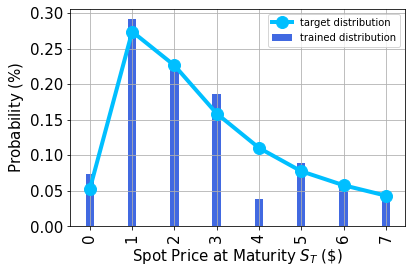

In [4]:
#Plot the probability distribution
#Next, we plot the trained probability distribution and, for reasons of comparison, also the target probability distribution.

# Evaluate trained probability distribution
values = [bounds[0] + (bounds[1] - bounds[0]) * x / (2 ** num_qubits - 1) for x in range(2**num_qubits)]
uncertainty_model = g_circuit.assign_parameters(dict(zip(theta, g_params)))
amplitudes = Statevector.from_instruction(uncertainty_model).data

x = np.array(values)
y = np.abs(amplitudes) ** 2

# Sample from target probability distribution
N = 100000
log_normal = np.random.lognormal(mean=1, sigma=1, size=N)
log_normal = np.round(log_normal)
log_normal = log_normal[log_normal <= 7]
log_normal_samples = []
for i in range(8):
    log_normal_samples += [np.sum(log_normal==i)]
log_normal_samples = np.array(log_normal_samples / sum(log_normal_samples))

# Plot distributions
plt.bar(x, y, width=0.2, label='trained distribution', color='royalblue')
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.grid()
plt.xlabel('Spot Price at Maturity $S_T$ (\$)', size=15)
plt.ylabel('Probability ($\%$)', size=15)
plt.plot(log_normal_samples,'-o', color ='deepskyblue', label='target distribution', linewidth=4, markersize=12)
plt.legend(loc='best')
plt.show()

Analytically calculated expected payoff w.r.t. the target distribution:  1.0581
Analytically calculated expected payoff w.r.t. the trained distribution: 0.9805


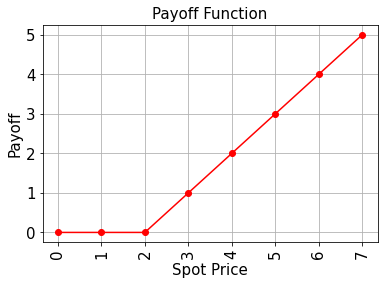

In [5]:
#Evaluate Expected Payoff
#Now, the trained uncertainty model can be used to evaluate the expectation value of the option’s payoff function analytically and 
#with Quantum Amplitude Estimation.

# Evaluate payoff for different distributions
payoff = np.array([0,0,0,1,2,3,4,5])
ep = np.dot(log_normal_samples, payoff)
print("Analytically calculated expected payoff w.r.t. the target distribution:  %.4f" % ep)
ep_trained = np.dot(y, payoff)
print("Analytically calculated expected payoff w.r.t. the trained distribution: %.4f" % ep_trained)

# Plot exact payoff function (evaluated on the grid of the trained uncertainty model)
x = np.array(values)
y_strike = np.maximum(0, x - strike_price)
plt.plot(x, y_strike, 'ro-')
plt.grid()
plt.title('Payoff Function', size=15)
plt.xlabel('Spot Price', size=15)
plt.ylabel('Payoff', size=15)
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.show()

In [6]:
# construct A operator for QAE
european_call = european_call_objective.compose(uncertainty_model, front=True)

In [7]:
# set target precision and confidence level
epsilon = 0.01
alpha = 0.05

# construct amplitude estimation
ae = IterativeAmplitudeEstimation(epsilon=epsilon, alpha=alpha,
                                  state_preparation=european_call,
                                  objective_qubits=[num_qubits],
                                  post_processing=european_call_objective.post_processing)

In [8]:
result = ae.run(quantum_instance=Aer.get_backend('qasm_simulator'), shots=100)

In [9]:
conf_int = np.array(result['confidence_interval'])
print('Exact value:        \t%.4f' % ep_trained)
print('Estimated value:    \t%.4f' % (result['estimation']))
print('Confidence interval:\t[%.4f, %.4f]' % tuple(conf_int))

Exact value:        	0.9805
Estimated value:    	0.9638
Confidence interval:	[0.8495, 1.0781]
